# Rabi Splitting with a Single-Mode Cavity: Non-socket mode

Here, we demonstrate the socket-free TLS workflow using the `maxwelllink.SingleModeSimulation` electromagnetic solver. By resonantly coupling one classical cavity mode to a two-level system (TLS), we monitor the cavity coordinate and verify the expected Rabi splitting in the frequency domain.

## 1. Defining Molecule

We first create a `Molecule` instance using the non-socket mode, i.e., we directly initialize the TLS within the `Molecule` class:

In [1]:
import numpy as np
import maxwelllink as mxl

frequency_au = 0.242
mu12 = 187

molecule = mxl.Molecule(
    driver="tls",
    driver_kwargs={
        "omega": frequency_au,
        "mu12": mu12,
        "orientation": 2,
        "pe_initial": 0e-3,
    }
)

[Init Molecule] Operating in non-socket mode, using driver: tls


## 2. Defining the single mode cavity

Then, we create a `SingleModeSimulation` instance which defines the parameters for a single harmonic oscillator. The pre-defined `molecule` is also attached to this class for coupled light-matter simulations.

This single-mode cavity obeys the following equations of motion:

$$
\dot{q} = p, \qquad
\dot{p} = -\omega_c^{2}\, q + g \sum_i \frac{d\mu_i}{dt} - \gamma_c\, p + D(t),
$$

aka,

$$
\ddot{q} = -\omega_c^{2}\, q + g \sum_i \frac{d\mu_i}{dt} - \gamma_c\, p + D(t),
$$

where the effective electric field of this cavity mode is

$$
E(t) = - g\, p(t) .
$$

Here, $g$ is the **coupling strength**, and the sum runs over the selected molecular axis of all molecules attaced to the ``SingleModeSimulation`` class. All quantities are in **atomic units**.


In [2]:

coupling_strength = 1e-4
dt_au = 0.5
damping_au = 0e-4
total_steps = 40960

sim = mxl.SingleModeSimulation(
    molecules=[molecule],
    frequency_au=frequency_au,
    coupling_strength=coupling_strength,
    damping_au=damping_au,
    coupling_axis=2,
    drive=0.0,
    dt_au=dt_au,
    qc_initial=1e-5,
    record_history=True,
)

print(
    f"Configured SingleModeSimulation with omega_c = {frequency_au:.3f} a.u. "
    f"and g = {coupling_strength:.3f} a.u."
)

sim.run(steps=total_steps)

init TLSModel with dt = 0.500000 a.u., molecule ID = 0
Configured SingleModeSimulation with omega_c = 0.242 a.u. and g = 0.000 a.u.


## 3. Retrieve simulation observables

After the simulation, we can retrieve the TLS trajectory from `molecule.additional_data_history` together with the cavity coordinate `q_c(t)` stored directly by `SingleModeSimulation`.

In [3]:
population = np.array([entry["Pe"] for entry in molecule.additional_data_history])
tls_time_au = np.array([entry["time_au"] for entry in molecule.additional_data_history])

qc_history = np.array(sim.qc_history)
time_history = np.array(sim.time_history)

print(
    f"Collected {population.size} TLS samples and {qc_history.size} cavity samples."
)

Collected 40960 TLS samples and 40961 cavity samples.


## 4. Inspect time-domain Rabi oscillations

Because the TLS is at resonance with the classical cavity mode, Rabi oscillations can be observed for this coupled system.



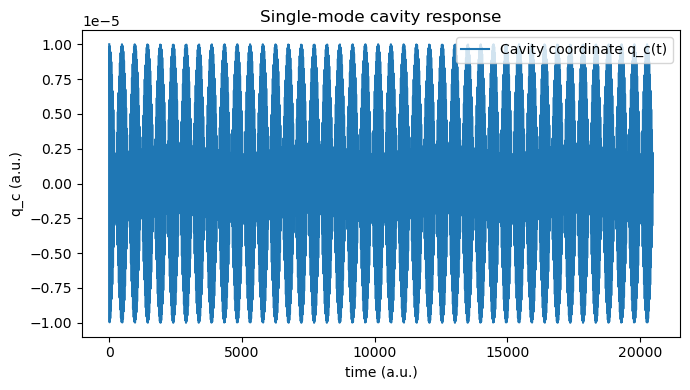

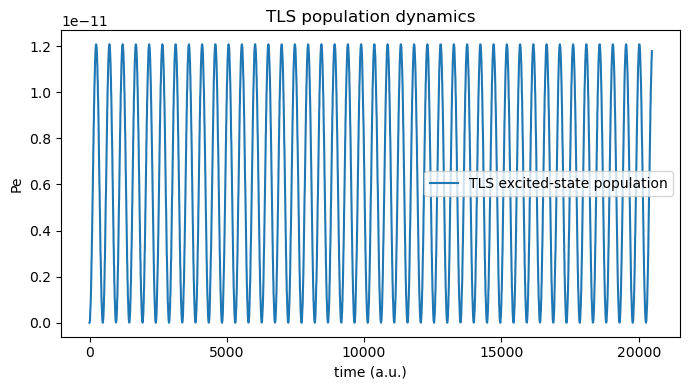

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(time_history, qc_history, label="Cavity coordinate q_c(t)")
plt.xlabel("time (a.u.)")
plt.ylabel("q_c (a.u.)")
plt.title("Single-mode cavity response")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(tls_time_au, population, label="TLS excited-state population")
plt.xlabel("time (a.u.)")
plt.ylabel("Pe")
plt.title("TLS population dynamics")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Fourier analysis of the cavity coordinate

Analytically, for this simple model system, we can calculate the assoicated Rabi splitting under the rotating wave approximation as:

$$
\Delta_{\rm{Rabi}} = g \mu_{12} \sqrt{\frac{2\omega}{\hbar}}
$$

We can of course obtain the numerical Rabi splitting by Fourier transforming the cavity coordinate dynamics, which can be compared with the above analytical solution.

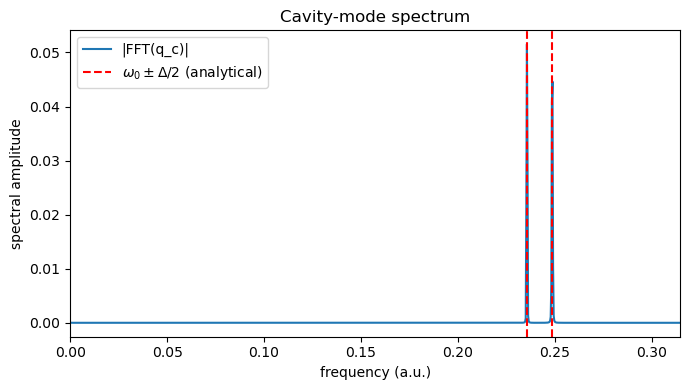

In [5]:
signal = qc_history - np.mean(qc_history)
if signal.size == 0:
    raise RuntimeError("No cavity data recorded; ensure the simulation was executed above.")

window = np.hanning(signal.size)
dt_sim = np.mean(np.diff(time_history)) if time_history.size > 1 else dt_au
fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(signal.size, d=dt_sim) * 2.0 * np.pi
spectrum = np.abs(fft_vals)

# analytical Rabi splitting
rabi_splitting = coupling_strength * mu12 * (2.0*frequency_au)**0.5

expected_peaks = np.array([
    frequency_au - rabi_splitting/2.0,
    frequency_au + rabi_splitting/2.0,
])

plt.figure(figsize=(7, 4))
plt.plot(freqs, spectrum, label="|FFT(q_c)|")
for idx, freq in enumerate(expected_peaks):
    label = r"$\omega_0 \pm \Delta/2$ (analytical)" if idx == 0 else None
    plt.axvline(freq, color="red", linestyle="--", label=label)
plt.xlim(0, frequency_au*1.3)
plt.xlabel("frequency (a.u.)")
plt.ylabel("spectral amplitude")
plt.title("Cavity-mode spectrum")
plt.legend()
plt.tight_layout()
plt.show()